# Naive Bayes

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Enable python to import modules from parent directory
import sys
sys.path.append("..")

from src.config import *

# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

In [2]:
data_path = os.path.join(DATA_CLEAN_PATH, "ml-curated-data.csv")
data = pd.read_csv(data_path, encoding='latin1')

In [3]:
data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,0.015672,0.01909,0.016816,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,0.015672,0.01909,0.016816,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,0.015672,0.01909,0.016816,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,0.015672,0.01909,0.016816,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,0.015672,0.01909,0.016816,0.028896


In [4]:
import random

def get_random_params():
    return {
        'var_smoothing': random.choice((range(1, 500)))
    }

In [5]:
def perform_fit(df, var_smoothing):
    
    naive_bayes = GaussianNB(var_smoothing=var_smoothing)
    
    train = data.sample(frac=0.7)
    test = data.drop(train.index)
    
    train_x = train.drop(columns=['wage_increase'])
    train_y = train['wage_increase']
    
    test_x = test.drop(columns=['wage_increase'])
    test_y = test['wage_increase']
    
    train_data_y = np.asarray(train_y, dtype="|S9")  # change type
    naive_bayes.fit(train_x, train_data_y)
    
    estimates = naive_bayes.predict(test_x)
    
    test_data_y_numeric = pd.to_numeric(test_y)
    estimates_numeric = pd.to_numeric(estimates)
    
    error = np.asmatrix(test_data_y_numeric - estimates_numeric)
    sme = (error.T * error / len(error)).tolist()[0][0]
    rsme = np.sqrt(sme)
    
    return rsme

In [6]:
def get_error_and_params(df, loop_quantity):
    
    errors_and_params = []

    for i in range(1, loop_quantity):
        
        params = get_random_params()
        var_smoothing = params.get('var_smoothing')
        rsme = perform_fit(df, var_smoothing)
        error_and_param = {'var_smoothing': var_smoothing, 'rsme': rsme}
        errors_and_params.append(error_and_param)
    
    return errors_and_params

In [7]:
errors_and_params = get_error_and_params(data, 5)

In [8]:
errors_and_params

[{'var_smoothing': 68, 'rsme': 0.012167916830807847},
 {'var_smoothing': 283, 'rsme': 0.05260132914031679},
 {'var_smoothing': 111, 'rsme': 0.033660093463441856},
 {'var_smoothing': 242, 'rsme': 0.005592245434565445}]

In [9]:
df_errors_and_params = pd.DataFrame(errors_and_params)

In [10]:
df_errors_and_params

,var_smoothing,rsme
0,68,0.012168
1,283,0.052601
2,111,0.033660
3,242,0.005592


In [11]:
rsmes = df_errors_and_params['rsme']

In [12]:
rsme = min(i for i in rsmes)
df_param_rsme = df_errors_and_params[df_errors_and_params.rsme == rsme]
df_param_rsme

,var_smoothing,rsme
3,242,0.005592


In [13]:
X = data.drop('wage_increase', axis=1)
y = data['wage_increase']

In [14]:
len(X)

11264

In [15]:
len(y)

11264

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [17]:
len(x_test)

3380

In [18]:
len(x_train)

7884

In [19]:
var_smoothing = df_param_rsme['var_smoothing'].values[0]

In [20]:
naive_bayes = GaussianNB(var_smoothing=var_smoothing)

In [21]:
naive_bayes

GaussianNB(priors=None, var_smoothing=242)

In [22]:
train_data_y = np.asarray(y_train, dtype="|S9")  # change type
naive_bayes.fit(x_train, train_data_y)

GaussianNB(priors=None, var_smoothing=242)

In [23]:
estimates = pd.to_numeric(naive_bayes.predict(x_test))

In [24]:
estimates

array([-0.008312, -0.01617 , -0.023088, ..., -0.023088, -0.023088,
       -0.013098])

In [25]:
len(estimates)

3380

In [27]:
len(y_test)

3380

In [28]:
real_test = pd.DataFrame({'estimates': estimates, 'test_estimates': y_test})

In [29]:
real_test

,estimates,test_estimates
3687,-0.008312,0.127114
8443,-0.016170,-0.072773
5198,-0.023088,0.038079
7788,-0.003057,0.163804
10238,-0.009550,0.042505
...,...,...
1216,-0.051339,0.271841
4479,-0.002154,0.026374
1804,-0.023088,0.100392
6016,-0.023088,0.046561


In [30]:
error = np.asmatrix(y_test - estimates)
sme = (error.T * error / len(error)).tolist()[0][0]
sme

0.018340285533933378

In [31]:
np.sqrt(sme)

0.13542631034600838

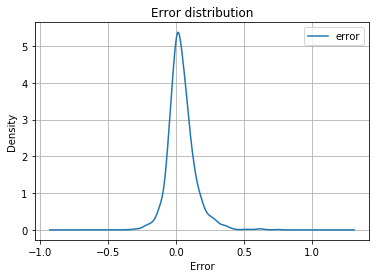

In [32]:
df_errors = pd.DataFrame({'error': [e for ls in error.tolist() for e in ls]})
df_errors.plot.kde()
plt.title("Error distribution")
plt.xlabel("Error")
plt.grid()
plt.show()

In [33]:
test_results = pd.DataFrame(
    {
    "y": estimates,
    "y_estimate": y_test
    }
)

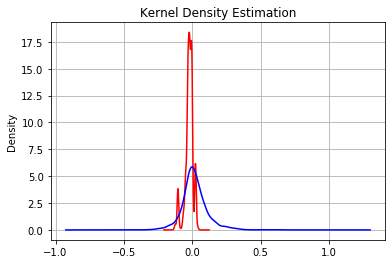

In [34]:
test_results.y.plot.kde(c='r')
test_results.y_estimate.plot.kde(c='b')
plt.title("Kernel Density Estimation")
plt.grid()
plt.show()

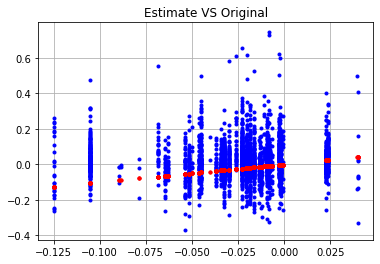

In [35]:
plt.plot(test_results.y, test_results.y_estimate, '.b')
plt.plot(test_results.y, test_results.y, '.r')
plt.title("Estimate VS Original")
plt.grid()
plt.show()